## 📈 Time Series Analysis: Stationarity, Smoothing & Model Evaluation

This notebook presents an **end-to-end time series analysis workflow**, covering data preprocessing, stationarity testing, smoothing techniques, and basic model evaluation.

The main objective is to understand the underlying structure of the time series and apply appropriate transformations before modeling, leading to more reliable and interpretable forecasts.

---

### 🔍 1. Stationarity Analysis
Stationarity is a key assumption for many classical time series models. In this notebook, the stationarity of the series is evaluated using both visual inspection and statistical testing.

- Mean and variance behavior are examined
- The **Augmented Dickey-Fuller (ADF) Test** is applied

**Hypotheses:**
- **H₀:** The time series is non-stationary  
- **H₁:** The time series is stationary  

Based on the p-value, the series is classified as stationary or non-stationary.

---

### 🧪 2. Smoothing Techniques
To reduce noise and better capture the underlying trend, several smoothing approaches are applied:

- **Moving Average**
- Rolling window-based smoothing

These techniques help:
- Suppress short-term fluctuations
- Highlight long-term trends in the data

---

### 🛠️ 3. Data Preparation & Train–Test Split
Before modeling:
- Missing values are handled using **time-based interpolation**
- A **time-aware train–test split** is performed to prevent data leakage

This approach better reflects real-world forecasting scenarios.

---

### 📊 4. Model Testing & Evaluation
Basic time series models are tested to evaluate predictive behavior.

At this stage:
- Model predictions are visualized
- Predicted values are compared with actual observations
- The model’s ability to capture trend and level is analyzed

This allows us to assess the impact of preprocessing and smoothing steps on model performance.

---

### 🎯 Conclusion
This notebook emphasizes that successful time series modeling starts **before** model training.

Key takeaways:
- The importance of stationarity checks
- The role of smoothing in trend analysis
- Proper train–test splitting for time series data

Together, these steps provide a strong foundation for building robust and interpretable time series forecasting models.


# 🔧 1. Import Required Libraries

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 📥 2. Loading the Dataset

In [12]:
data = sm.datasets.co2.load_pandas()
y = data.data
y.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [13]:
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Freq: W-SAT
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     2225 non-null   float64
dtypes: float64(1)
memory usage: 35.7 KB


# 📊 3. Time Series Resampling, Interpolation & Visualization


In [14]:
y = y["co2"].resample('MS').mean()

In [16]:
y = y.fillna(y.interpolate("time"))

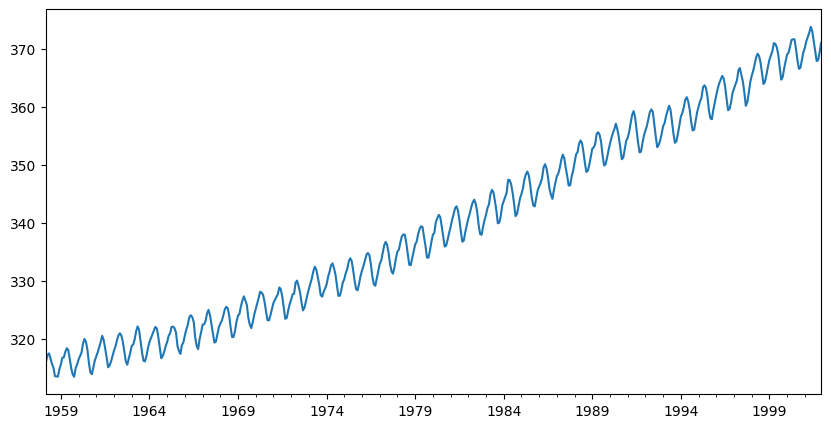

In [17]:
y.plot(figsize=(10,5))
plt.show()

In [19]:
train = y[:'1997-12-01']
print("Test :" , len(train))
test = y['1998-01-01':]
print("Train" , len(test))

Test : 478
Train 48


# 🧪 4. Stationarity Test with Augmented Dickey-Fuller (ADF)

In this step, the **Augmented Dickey-Fuller (ADF) test** is applied to statistically determine whether the time series is stationary.

- **H₀ (Null Hypothesis):** The time series is non-stationary  
- **H₁ (Alternative Hypothesis):** The time series is stationary  

The p-value returned by the ADF test is used to make the decision:
- If `p-value < 0.05`, the null hypothesis is rejected → **Stationary**
- Otherwise, the null hypothesis cannot be rejected → **Non-stationary**

This test provides a formal validation of stationarity before applying time series models.


In [26]:
p_value = sm.tsa.stattools.adfuller(y)[1]

# "HO: Non-stationary"
# "H1: Stationary"
if p_value < 0.05:
    print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
else:
    print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


# 📉 5. Time Series Decomposition (Trend, Seasonality & Residuals)


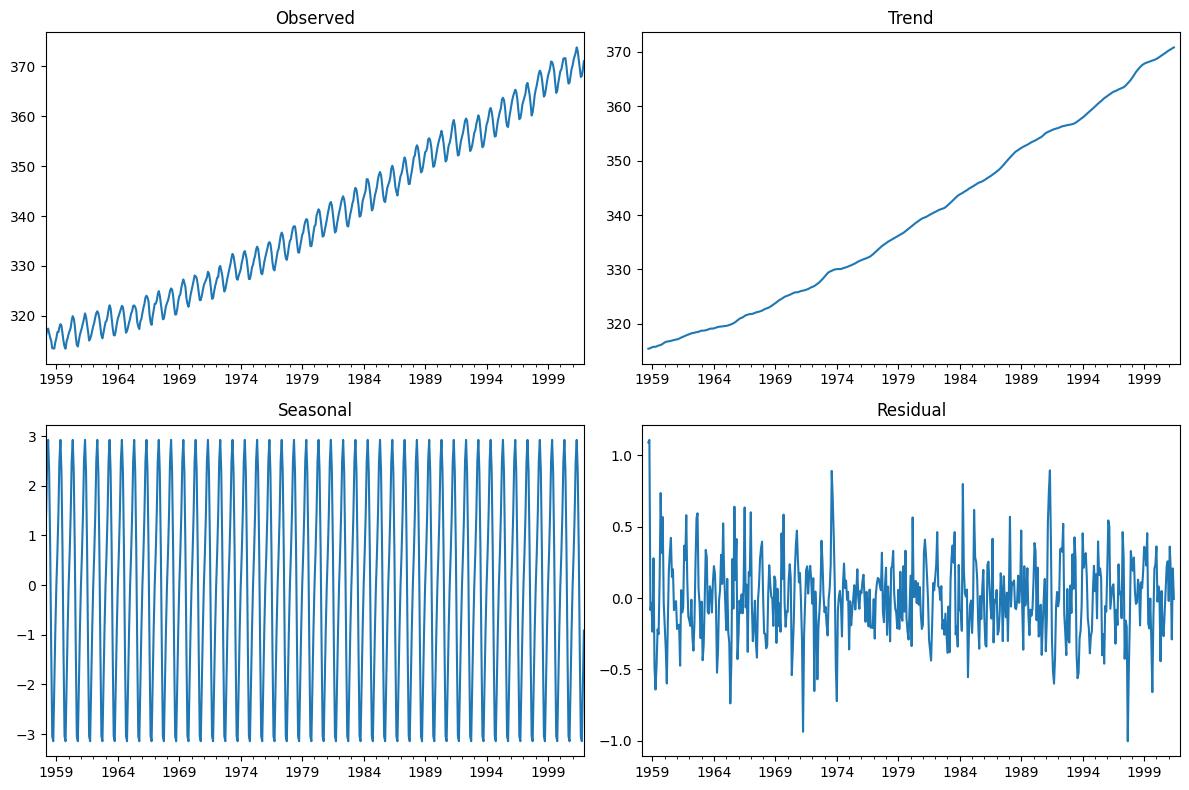

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose 

result = seasonal_decompose(y , model="additive")


plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title("Observed")
result.observed.plot()

plt.subplot(2, 2, 2)
plt.title("Trend")
result.trend.plot()

plt.subplot(2, 2, 3)
plt.title("Seasonal")
result.seasonal.plot()

plt.subplot(2, 2, 4)
plt.title("Residual")
result.resid.plot()

plt.tight_layout()
plt.show()

In [35]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error

ses_model = SimpleExpSmoothing(train).fit(smoothing_level = 0.5)

y_pred = ses_model.forecast(48)
mean_absolute_error(test , y_pred)



/usr/local/lib/python3.11/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


5.706393369643809

# 📈 6. Simple Exponential Smoothing (SES) Model Evaluation


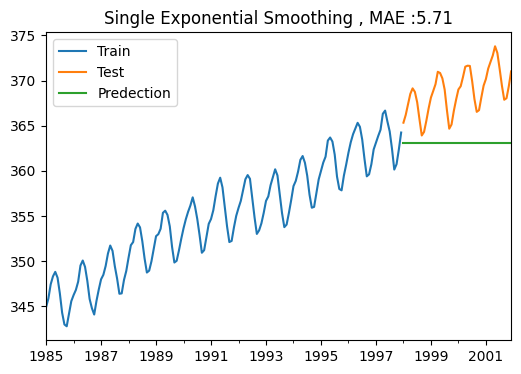

In [41]:
def plot_co2(train , test , y_pred , title):
    mae = mean_absolute_error(test, y_pred)
    train["1985" : ].plot(legend=True, label = "Train" , title = f"{title} , MAE :{round(mae,2)}")
    test.plot(legend=True, label="Test", figsize=(6, 4))
    y_pred.plot(legend=True , label = "Predection")
    plt.show()

plot_co2(train , test, y_pred , "Single Exponential Smoothing")
    

In [42]:
def ses_optimizer(train , alphas , step=48):
    best_alpha , best_mae = None , float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level = alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test , y_pred)
        if mae < best_mae:
            best_alpha , best_mae = alpha , mae
        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae
        
    

alphas = np.arange(0.8 , 1 , 0.01)
best_alpha , best_mae = ses_optimizer(train , alphas )



/usr/local/lib/python3.11/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress

alpha: 0.8 mae: 4.953
alpha: 0.81 mae: 4.9282
alpha: 0.82 mae: 4.9035
alpha: 0.83 mae: 4.8792
alpha: 0.84 mae: 4.8551
alpha: 0.85 mae: 4.8316
alpha: 0.86 mae: 4.8091
alpha: 0.87 mae: 4.7869
alpha: 0.88 mae: 4.765
alpha: 0.89 mae: 4.7434
alpha: 0.9 mae: 4.7221
alpha: 0.91 mae: 4.7012
alpha: 0.92 mae: 4.6805
alpha: 0.93 mae: 4.6602
alpha: 0.94 mae: 4.6402
alpha: 0.95 mae: 4.6205
alpha: 0.96 mae: 4.6012
alpha: 0.97 mae: 4.5822
alpha: 0.98 mae: 4.5634
alpha: 0.99 mae: 4.5451
best_alpha: 0.99 best_mae: 4.5451


/usr/local/lib/python3.11/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


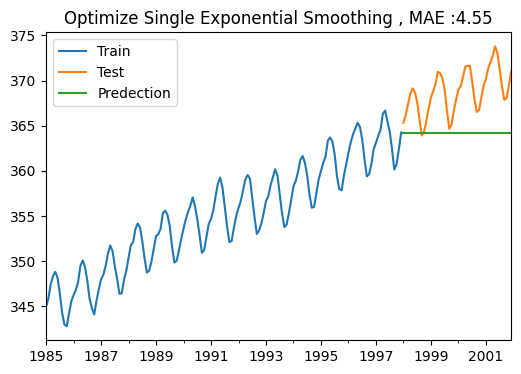

In [43]:
final_ses = SimpleExpSmoothing(train).fit(smoothing_level = best_alpha)
y_pred = final_ses.forecast(48)

plot_co2(train , test , y_pred , "Optimize Single Exponential Smoothing")

# 📈 7. Double Exponential Smoothing (Holt’s Method)


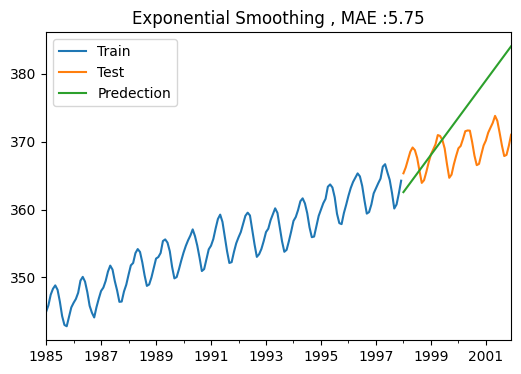

In [45]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

dse_model = ExponentialSmoothing(train , trend="add").fit(smoothing_level = 0.5 , smoothing_trend = 0.5)
y_pred = dse_model.forecast(48)

plot_co2(train , test , y_pred , "Exponential Smoothing")

In [49]:
def dse_optimize(train , alphas , betas , step=48):
    best_alpha , best_beta , best_mae = None , None , float("inf")
    for alpha in alphas:
        for beta in betas:
            dse_model = ExponentialSmoothing(train , trend="add").fit(smoothing_level = alpha , smoothing_trend = beta)
            y_pred = dse_model.forecast(48)
            mae = mean_absolute_error(test , y_pred)
            if mae < best_mae:
                best_alpha , best_beta , best_mae = alpha , beta , mae
                print("alpha : " , round(alpha , 2) , "beta :" , round(beta,2) , "mae :" , round(mae , 2))

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2))
    return best_alpha, best_beta, best_mae


alphas = np.arange(0.01 , 1 , 0.10)
betas = np.arange(0.01 , 1 , 0.10)
best_alpha, best_beta, best_mae = dse_optimize(train , alphas , betas)

    

alpha :  0.01 beta : 0.01 mae : 2.38
alpha :  0.01 beta : 0.31 mae : 2.17
alpha :  0.01 beta : 0.61 mae : 1.81
alpha :  0.01 beta : 0.71 mae : 1.74
best_alpha: 0.01 best_beta: 0.71


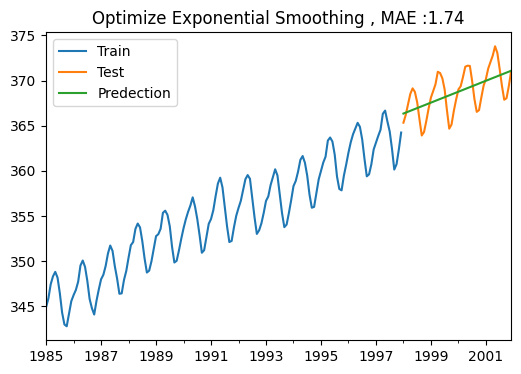

In [50]:
final_dse = ExponentialSmoothing(train , trend = "add").fit(smoothing_level = best_alpha , smoothing_trend = best_beta)
y_pred = final_dse.forecast(48)

plot_co2(train , test , y_pred , "Optimize Exponential Smoothing")

# 📈 8. Triple Exponential Smoothing (Holt–Winters Method)


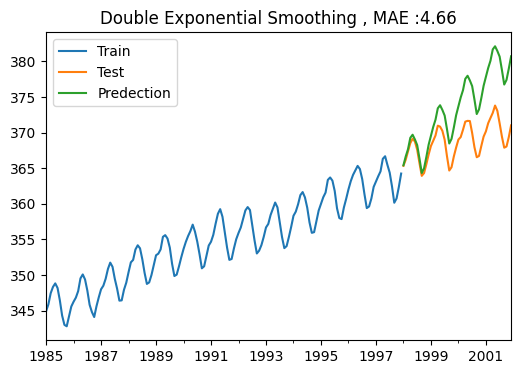

In [51]:
tse_model = ExponentialSmoothing(train , trend="add" , seasonal="add" , seasonal_periods = 12).fit(smoothing_level = 0.5 , smoothing_trend = 0.5 , smoothing_seasonal = 0.5)
y_pred = tse_model.forecast(48)

plot_co2(train , test , y_pred , "Double Exponential Smoothing")

In [55]:
import itertools

alphas = betas = gammas = np.arange(0.20 , 1 , 0.10)

abg = list(itertools.product(alphas, betas, gammas))

def tes_optimizer(train, abg ,step=48):
    best_alpha , best_beta , best_gamma , best_mae = None, None,None ,float("inf")
    for comb in abg:
        test_model = ExponentialSmoothing(train , trend="add" , seasonal="add" , seasonal_periods=12).fit(smoothing_level=comb[0], smoothing_trend=comb[1] , smoothing_seasonal=comb[2])
        y_pred = test_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
            print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae


best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg)

[0.2, 0.2, 0.2, 0.88]
[0.2, 0.2, 0.3, 0.79]
[0.2, 0.2, 0.4, 0.76]
[0.2, 0.2, 0.5, 0.75]
[0.2, 0.2, 0.6, 0.72]
[0.2, 0.2, 0.7, 0.67]
[0.2, 0.2, 0.8, 0.67]
[0.2, 0.6, 0.5, 0.64]
[0.2, 0.7, 0.5, 0.64]


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_

[0.8, 0.3, 0.6, 0.64]
[0.8, 0.5, 0.7, 0.59]
best_alpha: 0.8 best_beta: 0.5 best_gamma: 0.7 best_mae: 0.5858


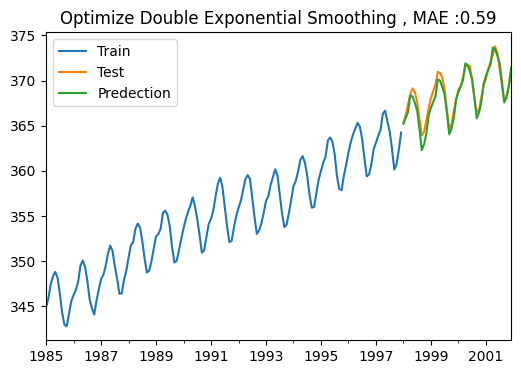

In [57]:
final_tes_model = ExponentialSmoothing(train , trend="add" , seasonal="add" , seasonal_periods=12).fit(smoothing_level=best_alpha , smoothing_trend=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_tes_model.forecast(48)

plot_co2(train, test, y_pred, "Optimize Double Exponential Smoothing")

## ✅ Final Result & Model Performance

The optimized **Exponential Smoothing model** successfully captures both the **trend** and **seasonal patterns** of the time series.

- The model closely follows the training data
- Forecasts align well with the test period
- Achieved a **low MAE of 0.59**, indicating strong predictive accuracy

Overall, the optimized smoothing parameters significantly improve forecasting performance, making this model well-suited for short-term time series prediction.
